# Introduction
This notebook goes through an example of running PK/PD model simulations and building a web app using Dash which can simulate based on inputs from the user

### Import the Required Libraries

In [1]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import plotly.graph_objs as go


Next we will define the PK/PD model in python that will be used for simulations

In [2]:
def pkpd_model(t, y, params):
    """
    Defines the system of ODEs for the PK/PD model.

    Parameters:
    - t (float): Current time point.
    - y (list or array): Current state variables [Gut, Central, Peripheral, Response].
    - params (dict): Dictionary of model parameters and individual random effects.

    Returns:
    - dydt (list): Derivatives of the state variables.
    """
    # Unpack state variables
    Gut = y[0]          # Amount of drug in the gut (absorption compartment)
    Central = y[1]      # Amount of drug in the central compartment
    Peripheral = y[2]   # Amount of drug in the peripheral compartment
    Response = y[3]     # Pharmacodynamic response

    # Unpack model parameters
    # Population parameters (typical values)
    Ka = params['Ka']       # Absorption rate constant (1/hr)
    CL = params['CL']       # Clearance from the central compartment (L/hr)
    Vc = params['Vc']       # Volume of the central compartment (L)
    Q = params['Q']         # Inter-compartmental clearance (L/hr)
    Vp = params['Vp']       # Volume of the peripheral compartment (L)
    kin = params['kin']     # Production rate constant of the response
    kout = params['kout']   # Loss rate constant of the response
    Imax = params['Imax']   # Maximum inhibitory effect
    IC50 = params['IC50']   # Concentration producing 50% of Imax

    # Individual random effects (between-subject variability)
    eta_CL = params.get('eta_CL', 0)   # Random effect on clearance
    eta_Vc = params.get('eta_Vc', 0)   # Random effect on central volume
    eta_Ka = params.get('eta_Ka', 0)   # Random effect on absorption rate constant

    # Apply random effects to individual parameters
    # Assuming log-normal distribution of parameters
    CLi = CL * np.exp(eta_CL)      # Individual clearance
    Vci = Vc * np.exp(eta_Vc)      # Individual central volume
    Kai = Ka * np.exp(eta_Ka)      # Individual absorption rate constant

    # Calculate rate constants
    K12 = Q / Vci                  # Rate constant from central to peripheral compartment
    K21 = Q / Vp                   # Rate constant from peripheral to central compartment
    K10 = CLi / Vci                # Elimination rate constant from central compartment

    # Calculate concentration in the central compartment
    Cc = Central / Vci             # Plasma concentration (mg/L)

    # Pharmacodynamic model: indirect response where the drug inhibits production
    Inhibition = Imax * Cc / (IC50 + Cc)   # Inhibitory effect as a function of concentration

    # Define the differential equations
    dGut = -Kai * Gut                            # Rate of change of drug in the gut
    dCentral = (Kai * Gut                        # Absorption into central compartment
                - K12 * Central                  # Distribution to peripheral compartment
                + K21 * Peripheral               # Distribution from peripheral compartment
                - K10 * Central)                 # Elimination from central compartment
    dPeripheral = K12 * Central - K21 * Peripheral   # Rate of change in peripheral compartment
    dResponse = kin * (1 - Inhibition) - kout * Response  # Rate of change of PD response

    # Return the derivatives as a list
    dydt = [dGut, dCentral, dPeripheral, dResponse]
    return dydt


## Step 3: Set Up Simulation Parameters and Initial Conditions
In this step, we will:

Define the population-level parameters and between-subject variability (BSV).
1. Set up the initial conditions for the state variables.
2. Specify the dosing regimen and simulation time.
3. Prepare to solve the ODEs.

In [3]:
# Step 3: Set Up Simulation Parameters and Initial Conditions

import numpy as np

# Population-level PK/PD parameters (typical values)
pop_params = {
    'Ka': 1.0,      # Absorption rate constant (1/hr)
    'CL': 1.0,      # Clearance from central compartment (L/hr)
    'Vc': 10.0,     # Volume of central compartment (L)
    'Q': 0.5,       # Inter-compartmental clearance (L/hr)
    'Vp': 20.0,     # Volume of peripheral compartment (L)
    'kin': 1.0,     # Production rate constant of response
    'kout': 0.5,    # Loss rate constant of response
    'Imax': 0.9,    # Maximum inhibitory effect
    'IC50': 2.0     # Concentration producing 50% of Imax
}

# Define between-subject variability (BSV) standard deviations (omegas)
omega = {
    'CL': 0.3,  # 30% variability in clearance
    'Vc': 0.2,  # 20% variability in central volume
    'Ka': 0.4   # 40% variability in absorption rate constant
}

# Number of subjects to simulate
n_subjects = 100  # You can adjust this number as needed

# Dosing regimen
dose = 100        # Dose amount (mg)
tau = 12          # Dosing interval (hours)
n_doses = 5       # Number of doses

# Dosing times
dose_times = np.arange(0, tau * n_doses, tau)

# Simulation time
# We simulate up to the last dosing time plus an additional dosing interval
t_end = dose_times[-1] + tau
time = np.linspace(0, t_end, 1000)  # Time points for simulation

# Initial conditions for the state variables
# [Gut, Central, Peripheral, Response]
y0 = [0, 0, 0, 1]  # Starting with no drug in the system and baseline response



## Step 4 Simulate the Model for Each Subject and Solve the ODEs

In this step we will:
1. Create a function to simulate the PK/PD model for each subject, incorporating dosing events and random effects.
2. Loop over the number of subjects to simulate individual profiles.
3. Solve the ODEs for each subject using scipy.integrate.solve_ivp.
4. Collect the results for all subjects for further analysis and visualization.



In [4]:
# Step 4: Simulate the Model for Each Subject and Solve the ODEs

from scipy.integrate import solve_ivp

# Initialize lists to store simulation results
all_time = []          # Time points for each subject
all_Cc = []            # Plasma concentrations for each subject
all_Response = []      # PD responses for each subject

# Function to simulate the model for a single subject
def simulate_subject(subject_id):
    """
    Simulates the PK/PD model for a single subject.

    Parameters:
    - subject_id (int): Identifier for the subject.

    Returns:
    - results (dict): Dictionary containing time points, plasma concentrations, and responses.
    """
    # Generate individual random effects (etas) for the subject
    eta_CL = np.random.normal(0, omega['CL'])
    eta_Vc = np.random.normal(0, omega['Vc'])
    eta_Ka = np.random.normal(0, omega['Ka'])

    # Combine population parameters with individual random effects
    params = pop_params.copy()
    params['eta_CL'] = eta_CL
    params['eta_Vc'] = eta_Vc
    params['eta_Ka'] = eta_Ka

    # Initial conditions for this subject
    y = y0.copy()  # Starting state variables

    # Initialize lists to collect results for this subject
    t_all = []     # Time points
    y_all = []     # State variables at each time point

    # Define dosing times including the end of simulation
    dosing_times = np.append(dose_times, t_end)

    # Loop over each dosing interval
    for i in range(len(dosing_times) - 1):
        # Time span for the current interval
        t_start = dosing_times[i]
        t_end_interval = dosing_times[i + 1]
        t_span = (t_start, t_end_interval)

        # Time points to evaluate within this interval
        t_eval = time[(time >= t_start) & (time <= t_end_interval)]

        # Solve the ODEs for the current interval
        sol = solve_ivp(
            fun=lambda t, y: pkpd_model(t, y, params),
            t_span=t_span,
            y0=y,
            t_eval=t_eval,
            method='RK45'  # You can choose other methods like 'BDF' if needed
        )

        # Update the state variables
        y = sol.y[:, -1]

        # Collect the results
        t_all.extend(sol.t)
        y_all.append(sol.y)

        # Apply dosing at the beginning of the next interval (if it's a dosing time)
        if dosing_times[i + 1] in dose_times:
            y[0] += dose  # Add dose to the Gut compartment

    # Concatenate results
    y_all = np.hstack(y_all)
    t_all = np.array(t_all)

    # Extract variables of interest
    Cc = y_all[1, :] / (params['Vc'] * np.exp(params['eta_Vc']))  # Plasma concentration
    Response = y_all[3, :]  # PD response

    # Store results
    results = {
        'time': t_all,
        'Cc': Cc,
        'Response': Response,
        'Subject': subject_id
    }
    return results

# Simulate the model for all subjects
for subject_id in range(1, n_subjects + 1):
    # Simulate subject
    subject_results = simulate_subject(subject_id)

    # Store results
    all_time.append(subject_results['time'])
    all_Cc.append(subject_results['Cc'])
    all_Response.append(subject_results['Response'])


## Step 5: Process Simulation Results and Create Plots
In this step, we will:

1. Process the simulation results to compute mean profiles and 90% prediction intervals for both PK (plasma concentration) and PD (response) data.
2. Prepare the data for plotting.
3. Create plots that display:
        The mean PK and PD profiles with shaded 90% prediction intervals.
        The individual PK and PD profiles for a subset of subjects.


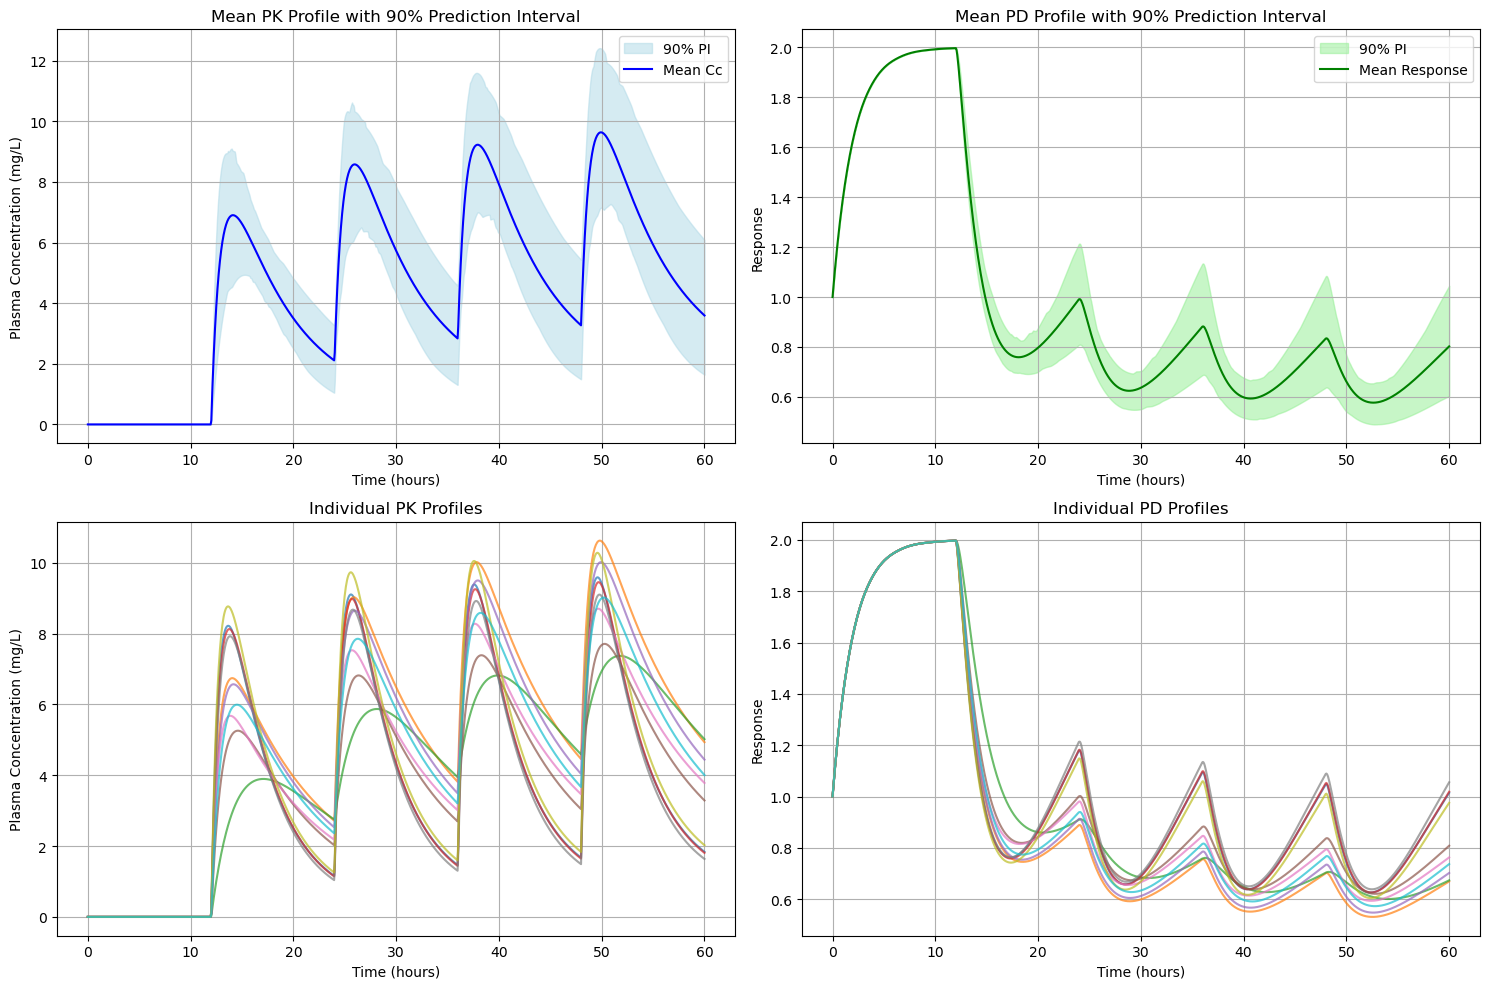

In [5]:
# Step 5: Process Simulation Results and Create Plots

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Convert simulation results to DataFrames for easier processing
# We'll assume that all subjects have the same time points
time_points = all_time[0]  # Time points are the same for all subjects

# Create DataFrames
df_Cc = pd.DataFrame(all_Cc).T  # Transpose to have time points as rows
df_Cc.columns = [f'Subject_{i+1}' for i in range(n_subjects)]
df_Cc['Time'] = time_points

df_Response = pd.DataFrame(all_Response).T
df_Response.columns = [f'Subject_{i+1}' for i in range(n_subjects)]
df_Response['Time'] = time_points

# Calculate mean and 90% prediction intervals for PK data (Cc)
mean_Cc = df_Cc.drop('Time', axis=1).mean(axis=1)
lower_Cc = df_Cc.drop('Time', axis=1).quantile(0.05, axis=1)
upper_Cc = df_Cc.drop('Time', axis=1).quantile(0.95, axis=1)

# Calculate mean and 90% prediction intervals for PD data (Response)
mean_Response = df_Response.drop('Time', axis=1).mean(axis=1)
lower_Response = df_Response.drop('Time', axis=1).quantile(0.05, axis=1)
upper_Response = df_Response.drop('Time', axis=1).quantile(0.95, axis=1)

# Prepare data for plotting individual profiles
# Select a subset of subjects for clarity (e.g., first 10 subjects)
subset_subjects = [f'Subject_{i+1}' for i in range(10)]  # Adjust number as needed

# Create plots
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# Plot Mean PK Profile with 90% Prediction Interval
ax1 = fig.add_subplot(gs[0, 0])
ax1.fill_between(time_points, lower_Cc, upper_Cc, color='lightblue', alpha=0.5, label='90% PI')
ax1.plot(time_points, mean_Cc, color='blue', label='Mean Cc')
ax1.set_title('Mean PK Profile with 90% Prediction Interval')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Plasma Concentration (mg/L)')
ax1.legend()
ax1.grid(True)

# Plot Mean PD Profile with 90% Prediction Interval
ax2 = fig.add_subplot(gs[0, 1])
ax2.fill_between(time_points, lower_Response, upper_Response, color='lightgreen', alpha=0.5, label='90% PI')
ax2.plot(time_points, mean_Response, color='green', label='Mean Response')
ax2.set_title('Mean PD Profile with 90% Prediction Interval')
ax2.set_xlabel('Time (hours)')
ax2.set_ylabel('Response')
ax2.legend()
ax2.grid(True)

# Plot Individual PK Profiles
ax3 = fig.add_subplot(gs[1, 0])
for subj in subset_subjects:
    ax3.plot(df_Cc['Time'], df_Cc[subj], alpha=0.7)
ax3.set_title('Individual PK Profiles')
ax3.set_xlabel('Time (hours)')
ax3.set_ylabel('Plasma Concentration (mg/L)')
ax3.grid(True)

# Plot Individual PD Profiles
ax4 = fig.add_subplot(gs[1, 1])
for subj in subset_subjects:
    ax4.plot(df_Response['Time'], df_Response[subj], alpha=0.7)
ax4.set_title('Individual PD Profiles')
ax4.set_xlabel('Time (hours)')
ax4.set_ylabel('Response')
ax4.grid(True)

plt.tight_layout()
plt.show()


# Building a web App for the Simulations

Import necessary libraries
Define the PK/PD Model Function


In [7]:

import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc  # Import DBC
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from scipy.integrate import solve_ivp



def pkpd_model(t, y, params):
    # Unpack state variables
    Gut, Central, Peripheral, Response = y
    
    # Unpack parameters
    Ka = params['Ka']
    CL = params['CL']
    Vc = params['Vc']
    Q = params['Q']
    Vp = params['Vp']
    kin = params['kin']
    kout = params['kout']
    Imax = params['Imax']
    IC50 = params['IC50']
    eta_CL = params.get('eta_CL', 0)
    eta_Vc = params.get('eta_Vc', 0)
    eta_Ka = params.get('eta_Ka', 0)
    
    # Apply random effects
    CLi = CL * np.exp(eta_CL)
    Vci = Vc * np.exp(eta_Vc)
    Kai = Ka * np.exp(eta_Ka)
    
    # Rate constants
    K12 = Q / Vci
    K21 = Q / Vp
    K10 = CLi / Vci
    
    # Plasma concentration
    Cc = Central / Vci
    
    # PD model
    Inhibition = Imax * Cc / (IC50 + Cc)
    
    # Differential equations
    dGut = -Kai * Gut
    dCentral = Kai * Gut - K12 * Central + K21 * Peripheral - K10 * Central
    dPeripheral = K12 * Central - K21 * Peripheral
    dResponse = kin * (1 - Inhibition) - kout * Response
    
    return [dGut, dCentral, dPeripheral, dResponse]


Define Subject Simulation Function


In [16]:

def simulate_subject(subject_id, dose, tau, n_doses, time, y0, dose_times, pop_params, omega):
    # Generate individual random effects
    eta_CL = np.random.normal(0, omega['CL'])
    eta_Vc = np.random.normal(0, omega['Vc'])
    eta_Ka = np.random.normal(0, omega['Ka'])

    # Combine parameters
    params = pop_params.copy()
    params['eta_CL'] = eta_CL
    params['eta_Vc'] = eta_Vc
    params['eta_Ka'] = eta_Ka

    # Initial conditions
    y = y0.copy()

    # Collect results
    t_all = []
    y_all = []

    # Loop over each dosing interval
    for i in range(len(dose_times)):
        t_start = dose_times[i]
        if i < len(dose_times) - 1:
            t_end_interval = dose_times[i + 1]
        else:
            t_end_interval = time[-1]

        t_span = (t_start, t_end_interval)

        # Apply dose at the start of the interval
        if t_start in dose_times:
            y[0] += dose  # Add dose to the Gut compartment

        # Adjust t_eval to include t_start explicitly
        t_eval = time[(time >= t_start) & (time <= t_end_interval)]
        if t_eval.size == 0 or t_eval[0] > t_start:
            t_eval = np.insert(t_eval, 0, t_start)

        # Solve the ODEs
        sol = solve_ivp(
            lambda t, y: pkpd_model(t, y, params),
            t_span,
            y,
            t_eval=t_eval,
            method='RK45'
        )

        # Update state variables
        y = sol.y[:, -1]

        # Collect results
        t_all.extend(sol.t)
        y_all.append(sol.y)

    # Concatenate results
    y_all = np.hstack(y_all)
    t_all = np.array(t_all)

    # Calculate plasma concentration and response
    Cc = y_all[1, :] / (params['Vc'] * np.exp(params['eta_Vc']))
    Response = y_all[3, :]

    return {'time': t_all, 'Cc': Cc, 'Response': Response}


Initialize the Dash App. Define the app layout and define the callback function

In [17]:
# Initialize the Dash app with Bootstrap stylesheet
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.FLATLY])
app.title = "PK/PD Simulation App"

# Define the app layout using Bootstrap components
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.H1("PK/PD Simulation"),
            html.Hr(),
            dbc.Form([
                # Use dbc.Row instead of dbc.FormGroup
                dbc.Row([
                    dbc.Label('Dose (mg):', width=4),
                    dbc.Col(
                        dbc.Input(id='dose', type='number', value=100, min=0, step=1),
                        width=8,
                    ),
                ], className="mb-3"),
                dbc.Row([
                    dbc.Label('Dosing Interval (hours):', width=4),
                    dbc.Col(
                        dbc.Input(id='tau', type='number', value=12, min=1, step=1),
                        width=8,
                    ),
                ], className="mb-3"),
                dbc.Row([
                    dbc.Label('Number of Doses:', width=4),
                    dbc.Col(
                        dbc.Input(id='n_doses', type='number', value=5, min=1, step=1),
                        width=8,
                    ),
                ], className="mb-3"),
                dbc.Row([
                    dbc.Label('Number of Subjects:', width=4),
                    dbc.Col(
                        dbc.Input(id='n_subjects', type='number', value=100, min=1, step=1),
                        width=8,
                    ),
                ], className="mb-3"),
                # Update the Button component
                dbc.Button(
                    'Simulate',
                    id='simulate-button',
                    n_clicks=0,
                    color='primary',
                    className='w-100'
                ),
            ]),
        ], width=3),
        dbc.Col([
            dcc.Graph(id='pkpd-plot')
        ], width=9),
    ], align='start'),
], fluid=True)

# Define the callback function
@app.callback(
    Output('pkpd-plot', 'figure'),
    Input('simulate-button', 'n_clicks'),
    State('dose', 'value'),
    State('tau', 'value'),
    State('n_doses', 'value'),
    State('n_subjects', 'value')
)
def update_graph(n_clicks, dose, tau, n_doses, n_subjects):
    if n_clicks == 0:
        return go.Figure()

    # Convert inputs
    dose = float(dose)
    tau = float(tau)
    n_doses = int(n_doses)
    n_subjects = int(n_subjects)

    # Population parameters
    pop_params = {
        'Ka': 1.0,
        'CL': 1.0,
        'Vc': 10.0,
        'Q': 0.5,
        'Vp': 20.0,
        'kin': 1.0,
        'kout': 0.5,
        'Imax': 0.9,
        'IC50': 2.0
    }

    omega = {
        'CL': 0.3,
        'Vc': 0.2,
        'Ka': 0.4
    }

    # Dosing regimen
    dose_times = np.arange(0, tau * n_doses, tau)

    # Simulation time
    t_end = dose_times[-1] + tau
    time = np.linspace(0, t_end, 1000)

    # Initial conditions
    y0 = [0, 0, 0, 1]

    # Initialize lists to store results
    all_Cc = []
    all_Response = []

    # Simulate for each subject
    for subject_id in range(n_subjects):
        results = simulate_subject(
            subject_id,
            dose,
            tau,
            n_doses,
            time,
            y0,
            dose_times,
            pop_params,
            omega
        )
        all_Cc.append(results['Cc'])
        all_Response.append(results['Response'])

    # Convert to numpy arrays
    all_Cc = np.array(all_Cc)
    all_Response = np.array(all_Response)

    # Calculate mean and prediction intervals
    mean_Cc = np.mean(all_Cc, axis=0)
    lower_Cc = np.percentile(all_Cc, 5, axis=0)
    upper_Cc = np.percentile(all_Cc, 95, axis=0)

    mean_Response = np.mean(all_Response, axis=0)
    lower_Response = np.percentile(all_Response, 5, axis=0)
    upper_Response = np.percentile(all_Response, 95, axis=0)

    # Create subplots with a specified template
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Mean PK Profile with 90% Prediction Interval',
            'Mean PD Profile with 90% Prediction Interval',
            'Individual PK Profiles',
            'Individual PD Profiles'
        ),
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )

    # Set the Plotly template for a cleaner look
    fig.update_layout(template='plotly_white')

    # Customize fonts and layout
    fig.update_layout(
        title={
            'text': 'PK/PD Simulation Results',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        ),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.1,
            xanchor="center",
            x=0.5
        ),
        height=800,
        width=1000
    )

    # Plot Mean PK with PI
    fig.add_trace(go.Scatter(
        x=results['time'], y=mean_Cc,
        mode='lines',
        line=dict(color='blue', width=2),
        name='Mean Cc',
        showlegend=False
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=np.concatenate([results['time'], results['time'][::-1]]),
        y=np.concatenate([lower_Cc, upper_Cc[::-1]]),
        fill='toself',
        fillcolor='rgba(173,216,230,0.3)',
        line=dict(color='rgba(173,216,230,0)'),
        hoverinfo="skip",
        showlegend=False
    ), row=1, col=1)

    # Plot Mean PD with PI
    fig.add_trace(go.Scatter(
        x=results['time'], y=mean_Response,
        mode='lines',
        line=dict(color='green', width=2),
        name='Mean Response',
        showlegend=False
    ), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=np.concatenate([results['time'], results['time'][::-1]]),
        y=np.concatenate([lower_Response, upper_Response[::-1]]),
        fill='toself',
        fillcolor='rgba(144,238,144,0.3)',
        line=dict(color='rgba(144,238,144,0)'),
        hoverinfo="skip",
        showlegend=False
    ), row=1, col=2)

    # Plot Individual PK Profiles
    for i in range(min(n_subjects, 10)):
        fig.add_trace(go.Scatter(
            x=results['time'], y=all_Cc[i],
            mode='lines',
            line=dict(width=1, color='blue'),
            opacity=0.6,
            showlegend=False
        ), row=2, col=1)

    # Plot Individual PD Profiles
    for i in range(min(n_subjects, 10)):
        fig.add_trace(go.Scatter(
            x=results['time'], y=all_Response[i],
            mode='lines',
            line=dict(width=1, color='green'),
            opacity=0.6,
            showlegend=False
        ), row=2, col=2)

    # Update axes titles and styles
    fig.update_xaxes(title_text='Time (hours)', row=1, col=1)
    fig.update_yaxes(title_text='Plasma Concentration (mg/L)', row=1, col=1)
    fig.update_xaxes(title_text='Time (hours)', row=1, col=2)
    fig.update_yaxes(title_text='Response', row=1, col=2)
    fig.update_xaxes(title_text='Time (hours)', row=2, col=1)
    fig.update_yaxes(title_text='Plasma Concentration (mg/L)', row=2, col=1)
    fig.update_xaxes(title_text='Time (hours)', row=2, col=2)
    fig.update_yaxes(title_text='Response', row=2, col=2)

    # Adjust margins
    fig.update_layout(margin=dict(t=80, b=50, l=50, r=50))

    return fig



## Run the App

In [18]:
# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)